In [1]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
    RemoveMessage
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId


#structuring
import ast
from langchain_core.output_parsers import JsonOutputParser
#error handling with output parser
from langchain.output_parsers import RetryOutputParser

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
from dotenv import load_dotenv 
from os import listdir
from os.path import isfile, join


# flask-san


load_dotenv()

True

In [2]:
GOOGLE_API_KEY=os.getenv('google_api_key')


In [3]:
GEMINI_MODEL='gemini-2.0-flash'

In [4]:
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [5]:
# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  node_message: str
  trip_data: dict
  query: str
  route:str

In [ ]:

class llm_nodes:

  def __init__(self, llm:any):
     self.model=llm
  def schedule_creator_node(self,state:State):
    llm=self.model
    parser = JsonOutputParser()
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm
    result=chain.invoke({"query": f'from this query: {state.get('query')} turn the data into a schedule into a json format in the output, do not include ```json```, do not include comments either'})
    try:

          result=parser.parse(result.content)
          return {'trip_data':result,
                  'node_message':result}
    except:
        try: 
          retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)
          result=retry_parser.parse_with_prompt(result.content, prompt)
          return {'trip_data':result,
                  'node_message':result}
        except:
          return {'trip_data':result.content,
                        'node_message': f'created the schedule:{result.content}, but formating failed '}
        


  def schedule_editor_node(self,state:State):
    """
    Tool to make modifications to the schedule such as add, delete or modify.
    Pass the query to the llm to edit the schedule.
    args: query - the query to edit the schedule.
    return: modified schedule in a json format
    """
    llm=self.model
    file=state['trip_data']
    # result=llm.invoke(f'Edit this schedule: {str(file)} following the instructions in the query: {query}, and include the changes in the schedule, but do not mention them specifically, only include the updated schedule json format in the output, do not include ```json```, do not include comments either')
    parser = JsonOutputParser()
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm
    result=chain.invoke({"query":  f'Edit this schedule: {str(file)} following the instructions in the query: {state.get('query')}, and include the changes in the schedule, but do not mention them specifically, only include the updated schedule json format in the output, do not include ```json```, do not include comments either'})
    try:
          
          result=parser.parse(result.content)
          return {'trip_data':result,
                  'node_message': f'edited the schedule with these changes:{result}'}
    except:
        try: 
          retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)
          result=retry_parser.parse_with_prompt(result.content, prompt)
          return {'trip_data':result,
                  'node_message': f'edited the schedule with these changes:{result}'}
        except:
          return {'trip_data':result.content,
                        'node_message': f'edited the schedule with these changes:{result}, but formating failed '}
        
        
  def agent_node(self,state:State):
      llm=self.model
      class Form(BaseModel):
          route: str = Field(description= 'Return one of: schedule_creator, schedule_editor, show_schedule')
          
      parser=JsonOutputParser(pydantic_object=Form)
      instruction=parser.get_format_instructions()
      response=llm.invoke([HumanMessage(content=f"Based on this query: {state['query']}, select the appropriate route. Options are: schedule_creator, schedule_editor, show_schedule\n\n{instruction}")])
      response=parser.parse(response.content)
      route=response.get('route')

      return {'route':route}
  
  def show_schedule_node(self,state: State):
    """
    Use this tool to get the information about the schedule once it has been loaded.
    args: none
    return: schedule
    """
    schedule=state.get('trip_data')
    if schedule:
      return {"node_message":schedule}
    else:
       return{"node_message":"no schedule found, please upload one or add it in the chat"}
    



In [7]:
def route(state:State):
    route=state.get('route')
    routing_map={
    'schedule_creator': 'to_schedule_creator',
    'schedule_editor': 'to_schedule_editor',
    'show_schedule': 'to_show_schedule'
    }
    return routing_map.get(route)

In [8]:
# langgraph
#loading tools
class Schedule_agent:
    def __init__(self, llm:any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
        nodes=llm_nodes(llm)
   

        graph_builder = StateGraph(State)


        graph_builder.add_node("agent",nodes.agent_node)


        graph_builder.add_node('schedule_creator', nodes.schedule_creator_node)
        graph_builder.add_node('schedule_editor', nodes.schedule_editor_node)
        graph_builder.add_node('show_schedule',nodes.show_schedule_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("agent")
        graph_builder.add_conditional_edges(
            "agent",
            route,{
                'to_schedule_creator': 'schedule_creator',
                'to_schedule_editor': 'schedule_editor',
                'to_show_schedule': 'show_schedule'
            }
        )
        graph_builder.add_edge('schedule_creator',END)
        graph_builder.add_edge('schedule_editor',END)
        graph_builder.add_edge('show_schedule',END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input
                                    },config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input
                                        }, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]
    
    def update_state(self, data: dict):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.update_state(config, data)


In [9]:
agent=Schedule_agent(llm)

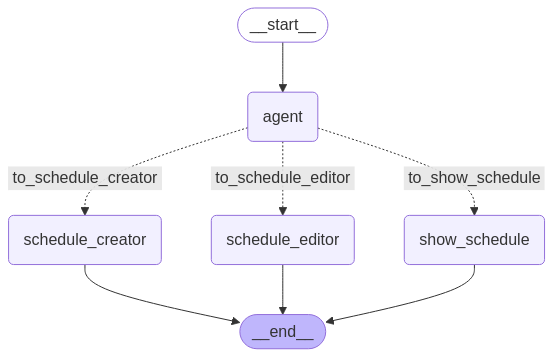

In [10]:
agent.display_graph()

In [11]:

agent.stream('create a schedule for:  monday: 10 am: gym, 10pm: sleep, tuesday: 9 am: wake tf up, 10pm : slleepy ')

{'agent': {'route': 'schedule_creator'}}
{'schedule_creator': {'trip_data': {'schedule': {'monday': {'10:00 AM': 'gym', '10:00 PM': 'sleep'}, 'tuesday': {'9:00 AM': 'wake tf up', '10:00 PM': 'slleepy'}}}, 'node_message': {'schedule': {'monday': {'10:00 AM': 'gym', '10:00 PM': 'sleep'}, 'tuesday': {'9:00 AM': 'wake tf up', '10:00 PM': 'slleepy'}}}}}


In [12]:
agent.get_state('messages')

KeyError: 'messages'